In [1]:
import os
import sys
import datetime
from pathlib import Path
import xml.etree.ElementTree as ET
import logging
import uuid
import time
import shapely
import pandas as pd
pd.options.plotting.backend = "plotly"
import geopandas as gpd
import seaborn
import dask
import numpy as np
import dask.dataframe as dd
from dask.distributed import Client

sys.path.insert(0, '..')
import src.hotspot_utils as util 
import src.process_nearest_hotspots as nearest_process
import src.xml_util as xutil

/env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
outdir = Path(f"/home/jovyan/s3vt_dask/s3vtdata/workdir_test1")

In [3]:
logging.basicConfig(
    format='%(asctime)s [%(levelname)s] %(name)s - %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
)
_LOG = logging.getLogger(__name__)

In [4]:
# include n_workers equal or less than the number of core
# To visualise status in Dask add /user/<username>/proxy/8787/status
client = Client(n_workers=4)
client

Client Scheduler: tcp://127.0.0.1:36793 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 66.57 GB


# Processing Parameter used in Sub-setting Spatial Extent and Temporal Range for Area of Interest
##### The FRP data from nasa, esa, eumetsat and landgate are merged, sub-setted and neareast hotspots csv files are generated based on the parameters in `processing_parameters`  
##### The parameter `chunks` in blocking FRP data to enable multi-processing. If you encounter memory issues then higher the number.
##### The `start_time` and `end_time` can be used to subset for solar_day (3:00-22:00), solar_night (22:00-03:00 with 12 hours offset) and solar_all(0:00-24:00) hours.

In [5]:
processing_parameters = {
    "nasa_frp": "s3://s3vtaustralia/nasa_hotspots_gdf.geojson",
    "esa_frp": "s3://s3vtaustralia/s3vt_hotspots.geojson",
    "eumetsat_frp": "s3://s3vtaustralia/s3vt_eumetsat_hotspots.geojson",
    "landgate_frp": "s3://s3vtaustralia/landgate_hotspots_gdf.geojson",
    "sentinel3_swath_geojson": "s3://s3vtaustralia/sentinel3_swath_gdfs.geojson",
    "dea_frp": None,
    "lon_west": 147.0,
    "lat_south": -38.0,
    "lon_east": 154.0,
    "lat_north": -27.,
    "start_date": "2019-11-01",
    "end_date": "2020-10-08",
    "start_time": "20:00",
    "end_time": "03:00",
    "chunks": 250,
    "compare_field": "solar_night",
    "swath_config_file": Path("/home/jovyan/s3vt_dask/s3vtdata/configs/s3vtconfig.yaml"),
    "outdir": outdir,
    "test": False
}

In [6]:
# This is to generate nearest .csv files. If .csv files already exists then skip this process. Takes around ~5-6 hours in this sandbox environment with 2-core and 16 GB RAM
nearest_hotspots_product_files = nearest_process.process_nearest_points(**processing_parameters)

2021-10-04 03:57:49,003: INFO: /home/jovyan/s3vt_dask/s3vtdata/workdir_test1/all_hotspots_154_147_20191101_20201008_2000_0300.pkl exists. Reading hotspots GeoDataFrame from the file.
2021-10-04 03:57:52,951: INFO: Processing subset between 09:44 and 17:12 utc time
2021-10-04 03:57:54,103: INFO: Processing Neareast Hotspots...
2021-10-04 03:57:54,118: INFO: /home/jovyan/s3vt_dask/s3vtdata/workdir_test1/swaths_154_147_20191101_20201008.pkl exists. Reading Swath GeoDataFrame from the file.


                     latitude  longitude satellite sensor  confidence  power  \
datetime                                                                       
2019-12-04 14:06:00 -30.06377  152.13608   NOAA 20  VIIRS        50.0    7.0   
2019-12-04 14:06:00 -33.95615  150.34776   NOAA 20  VIIRS        50.0    3.5   
2019-12-04 14:06:00 -33.95773  150.35387   NOAA 20  VIIRS        50.0    3.6   
2019-12-04 14:06:00 -33.95880  150.35799   NOAA 20  VIIRS        50.0    3.6   
2019-12-04 14:06:00 -33.96070  150.36525   NOAA 20  VIIRS        50.0    1.6   

                               datetime           solar_day  \
datetime                                                      
2019-12-04 14:06:00 2019-12-04 14:06:00 2019-12-05 00:14:32   
2019-12-04 14:06:00 2019-12-04 14:06:00 2019-12-05 00:07:23   
2019-12-04 14:06:00 2019-12-04 14:06:00 2019-12-05 00:07:24   
2019-12-04 14:06:00 2019-12-04 14:06:00 2019-12-05 00:07:25   
2019-12-04 14:06:00 2019-12-04 14:06:00 2019-12-05 00:07:27  

2021-10-04 03:57:54,758: INFO: Generating neareast hotspots...
2021-10-04 03:57:54,886: INFO: /home/jovyan/s3vt_dask/s3vtdata/workdir_test1/nearest_points_NOAA 20_VIIRS_NASA2.0NRT_2000_0300.csv exists. skipped nearest hotspots processing for product NOAA 20_VIIRS_NASA2.0NRT. Same file will be used in analysis.
2021-10-04 03:57:54,886: INFO: /home/jovyan/s3vt_dask/s3vtdata/workdir_test1/nearest_points_SUOMI NPP_VIIRS_NASA1_2000_0300.csv exists. skipped nearest hotspots processing for product SUOMI NPP_VIIRS_NASA1. Same file will be used in analysis.
2021-10-04 03:57:54,887: INFO: /home/jovyan/s3vt_dask/s3vtdata/workdir_test1/nearest_points_TERRA_MODIS_NASA6.03_2000_0300.csv exists. skipped nearest hotspots processing for product TERRA_MODIS_NASA6.03. Same file will be used in analysis.
2021-10-04 03:57:54,887: INFO: /home/jovyan/s3vt_dask/s3vtdata/workdir_test1/nearest_points_AQUA_MODIS_NASA6.03_2000_0300.csv exists. skipped nearest hotspots processing for product AQUA_MODIS_NASA6.03. S

## Nearest Hotspots DataFrame merged from neareast hotspots csv files

In [7]:
# csv directory is where nearest hotspots csv files are stored. 
csv_directory = outdir
print(csv_directory)
# This is read all the .csv files if name starts with `nearest_points` and ends with `compare_field` value from processing parameters.
nearest_hotspots_csv_files = [
    fp for fp in csv_directory.iterdir()
    if (fp.name.startswith("nearest_points"))
    and (fp.name.endswith("csv"))
]

/home/jovyan/s3vt_dask/s3vtdata/workdir_test1


In [8]:
# nearest points csv files that will be used analysis from here on.
nearest_hotspots_csv_files

[PosixPath('/home/jovyan/s3vt_dask/s3vtdata/workdir_test1/nearest_points_AQUA_MODIS_NASA6.03_2000_0300.csv'),
 PosixPath('/home/jovyan/s3vt_dask/s3vtdata/workdir_test1/nearest_points_SENTINEL_3B_SLSTR_ESA_2000_0300.csv'),
 PosixPath('/home/jovyan/s3vt_dask/s3vtdata/workdir_test1/nearest_points_SENTINEL_3A_SLSTR_EUMETSAT_2000_0300.csv'),
 PosixPath('/home/jovyan/s3vt_dask/s3vtdata/workdir_test1/nearest_points_SENTINEL_3B_SLSTR_EUMETSAT_2000_0300.csv'),
 PosixPath('/home/jovyan/s3vt_dask/s3vtdata/workdir_test1/nearest_points_SUOMI NPP_VIIRS_NASA1_2000_0300.csv'),
 PosixPath('/home/jovyan/s3vt_dask/s3vtdata/workdir_test1/nearest_points_NOAA 20_VIIRS_NASA2.0NRT_2000_0300.csv'),
 PosixPath('/home/jovyan/s3vt_dask/s3vtdata/workdir_test1/nearest_points_NOAA 20_VIIRS_LANDGATE_2000_0300.csv'),
 PosixPath('/home/jovyan/s3vt_dask/s3vtdata/workdir_test1/nearest_points_TERRA_MODIS_LANDGATE_2000_0300.csv'),
 PosixPath('/home/jovyan/s3vt_dask/s3vtdata/workdir_test1/nearest_points_SUOMI NPP_VIIRS_LAND

In [9]:
# returns a dask DataFrame with index set at column `compare_field` from processing_parameters.
nearest_points_ddf = util.csv_to_dataframe(nearest_hotspots_csv_files, processing_parameters["compare_field"])

2021-10-04 03:58:13,514: INFO: Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-10-04 03:58:13,515: INFO: NumExpr defaulting to 8 threads.
2021-10-04 03:58:13,535: INFO: Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-10-04 03:58:13,551: INFO: NumExpr defaulting to 8 threads.


In [10]:
nearest_points_ddf = nearest_points_ddf.compute()

In [90]:
satellite_sensor_product = nearest_points_ddf.satellite_sensor_product.unique()
satellite_sensor_product_daily_list = []
for i in satellite_sensor_product:
    
    for j in satellite_sensor_product:
        if i != j:
            Acount = nearest_points_ddf[(nearest_points_ddf['satellite_sensor_product'] == i) & (nearest_points_ddf['2_satellite_sensor_product'] == j)].resample("D", on='datetime').datetime.count()
            Acount = Acount.rename('master_count')
            Bcount = nearest_points_ddf[(nearest_points_ddf['satellite_sensor_product'] == j) & (nearest_points_ddf['2_satellite_sensor_product'] == i)].resample("D", on='datetime').datetime.count()
            Bcount = Bcount.rename('slave_count')
            
            # Use the ratio of the master and slave daily counts in the same observation extent as a consistency measure
            # - theory being that there should be a proportional shift in both hotspot sources
            # - using ratio as a quick measure
            
            ratio = Acount/Bcount
            ratio = ratio.rename('ratio')
           
            zscore = ratio - ratio.mean() / ratio.std()
            zscore = zscore.rename('zscore')

            satellite_sensor_product_daily = pd.concat([Acount, Bcount, ratio, zscore], axis=1)
            satellite_sensor_product_daily['satellite_sensor_product'] = i
            satellite_sensor_product_daily['2_satellite_sensor_product'] = j
            satellite_sensor_product_daily['pair'] = i+'|'+j
            satellite_sensor_product_daily_list.append(satellite_sensor_product_daily)
            print(i,j,ratio.max(),ratio.std(),ratio.mean())
satellite_sensor_product_daily_pd = pd.concat(satellite_sensor_product_daily_list)

SENTINEL_3B_SLSTR_ESA SENTINEL_3A_SLSTR_ESA 0.7727272727272727 nan 0.7727272727272727
SENTINEL_3B_SLSTR_ESA TERRA_MODIS_NASA6.03 77.0 14.665784954089334 10.036026634955089
SENTINEL_3B_SLSTR_ESA TERRA_MODIS_LANDGATE 77.0 14.918923442683496 6.022618844045334
SENTINEL_3B_SLSTR_ESA AQUA_MODIS_LANDGATE 61.6 12.804753182971462 5.84924420367362
SENTINEL_3B_SLSTR_ESA AQUA_MODIS_NASA6.03 78.0 19.045934275752547 16.42698407743961
SENTINEL_3B_SLSTR_ESA SUOMI NPP_VIIRS_LANDGATE 61.142857142857146 11.542258031545183 3.298003257372884
SENTINEL_3B_SLSTR_ESA SUOMI NPP_VIIRS_NASA1 1.7469387755102042 0.31171999413194157 0.4702663250933899
SENTINEL_3B_SLSTR_ESA NOAA 20_VIIRS_LANDGATE 1.5639810426540284 0.3269611766900415 0.45235918099010863
SENTINEL_3B_SLSTR_ESA SENTINEL_3B_SLSTR_EUMETSAT 1.0584192439862543 0.016346905376740547 1.0051324377933264
SENTINEL_3B_SLSTR_ESA SENTINEL_3A_SLSTR_EUMETSAT nan nan nan
SENTINEL_3B_SLSTR_ESA NOAA 20_VIIRS_NASA2.0NRT 0.6137466307277628 0.18063303960915314 0.34971655812

In [302]:
satellite_sensor_product_daily_pd.zscore.max()

1297.7930548221461

In [91]:
pairs = list(satellite_sensor_product_daily_pd['pair'].unique())

In [109]:
satellite_sensor_product_daily.satellite_sensor_product.unique()

array(['NOAA 20_VIIRS_NASA2.0NRT'], dtype=object)

In [124]:
pair_list = []
pair_dict = {}
for pair in pairs:
    daily_pair = satellite_sensor_product_daily_pd[satellite_sensor_product_daily_pd['pair'] == pair]
    correlation = daily_pair[['master_count','slave_count']].corr().master_count[1]
    #pair_list.append(pd.DataFrame({pair: {'correlation': correlation}}))
    pair_dict[pair] = {'correlation': correlation, 'master': pair.split('|')[0], 'slave': pair.split('|')[1]}
pair_pd = pd.DataFrame(pair_dict).transpose()

In [134]:
for master in pair_pd['master'].unique():
    print(pair_pd[pair_pd['master'] == master][['correlation']].sort_values(by=['correlation'], ascending=False))

                                                 correlation
SENTINEL_3B_SLSTR_ESA|SENTINEL_3B_SLSTR_EUMETSAT    0.999989
SENTINEL_3B_SLSTR_ESA|NOAA 20_VIIRS_NASA2.0NRT      0.953632
SENTINEL_3B_SLSTR_ESA|SUOMI NPP_VIIRS_NASA1         0.951214
SENTINEL_3B_SLSTR_ESA|NOAA 20_VIIRS_LANDGATE        0.947815
SENTINEL_3B_SLSTR_ESA|TERRA_MODIS_NASA6.03          0.896469
SENTINEL_3B_SLSTR_ESA|AQUA_MODIS_NASA6.03           0.875173
SENTINEL_3B_SLSTR_ESA|SUOMI NPP_VIIRS_LANDGATE      0.868757
SENTINEL_3B_SLSTR_ESA|AQUA_MODIS_LANDGATE           0.837938
SENTINEL_3B_SLSTR_ESA|TERRA_MODIS_LANDGATE          0.706158
SENTINEL_3B_SLSTR_ESA|SENTINEL_3A_SLSTR_ESA              NaN
                                                 correlation
SENTINEL_3A_SLSTR_ESA|SENTINEL_3A_SLSTR_EUMETSAT    0.999979
SENTINEL_3A_SLSTR_ESA|SUOMI NPP_VIIRS_NASA1          0.97001
SENTINEL_3A_SLSTR_ESA|TERRA_MODIS_LANDGATE          0.943507
SENTINEL_3A_SLSTR_ESA|NOAA 20_VIIRS_NASA2.0NRT      0.940076
SENTINEL_3A_SLSTR_ESA|SU

In [13]:
sample = satellite_sensor_product_daily_pd[(satellite_sensor_product_daily_pd['pair'] == 'NOAA 20_VIIRS_NASA2.0NRT|SENTINEL_3A_SLSTR_EUMETSAT')]
#sample = satellite_sensor_product_daily_pd[(satellite_sensor_product_daily_pd['satellite_sensor_product'] == 'SUOMI NPP_VIIRS_LANDGATE') & (satellite_sensor_product_daily_pd['2_satellite_sensor_product'] == 'SUOMI NPP_VIIRS_NASA1')]#.plot()

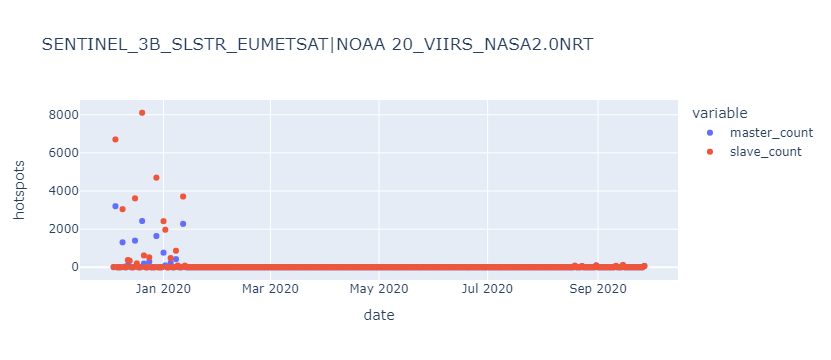

In [354]:
# Cut and paste pair from above to visualise daily pair counts (from coincident observation area)
# Theory is that within in some range, the number of hotspots should be roughly proportional, day to day.
pair = 'SENTINEL_3B_SLSTR_EUMETSAT|NOAA 20_VIIRS_NASA2.0NRT'

example = satellite_sensor_product_daily_pd[satellite_sensor_product_daily_pd['pair'] == pair]
ax = example.plot.scatter(x=example.index, y=['master_count', 'slave_count'], title=pair)
ax.layout.xaxis = {    'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'date'}}
ax.layout.yaxis = {    'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'hotspots'}}
#ax.layout.legend = {    'title': {'satellite_sensor_product': 'variable'}, 'tracegroupgap': 0}
ax

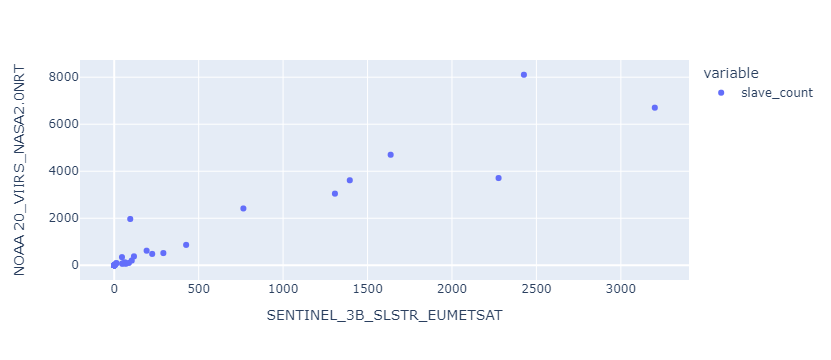

In [347]:
ax = example.plot.scatter(x=example['master_count'], y=['slave_count'])
ax.layout.xaxis = {    'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'SENTINEL_3B_SLSTR_EUMETSAT'}}
ax.layout.yaxis = {    'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'NOAA 20_VIIRS_NASA2.0NRT'}}
ax

In [355]:
# Create a dictionary to enable interactive plotting with dropdown menu using Plotly
#pair_dict = {}
#for pair in pairs:
#    pair_results = satellite_sensor_product_daily_pd[satellite_sensor_product_daily_pd['pair'] == pair][['master_count', 'slave_count']].to_dict()
    
#    pair_dict[pair] = [pd.Series(pair_results['master_count']).index.strftime('%Y-%m-%d'),
#                       pd.Series(pair_results['slave_count']).index.strftime('%Y-%m-%d')]
    

In [356]:
#pd.Series(pair_results['master_count']).index.strftime('%Y-%m-%d')

In [357]:
#df = pd.DataFrame(pair_dict)
#df = df.transpose()

In [358]:
#df

In [264]:
# Failed. Timestamp needs to be a string - 
'''
import plotly.graph_objs as go
import pandas as pd

# plotly figure setup
fig = go.Figure()

# one trace for each df column
for col in df.columns:
    fig.add_trace(go.Scatter(x=df.index, y=df[col].values,
                             name = col,
                             mode = 'lines')
                 )

# one button for each df column
updatemenu= []
buttons=[]
for col in df.columns:
    buttons.append(dict(method='restyle',
                        label=col,
                        args=[{'y':[df[col].values]}])
                  )

# some adjustments to the updatemenu
updatemenu=[]
your_menu=dict()
updatemenu.append(your_menu)
updatemenu[0]['buttons']=buttons
updatemenu[0]['direction']='down'
updatemenu[0]['showactive']=True

# update layout and show figure
fig.update_layout(updatemenus=updatemenu)
'''

"\nimport plotly.graph_objs as go\nimport pandas as pd\n\n# plotly figure setup\nfig = go.Figure()\n\n# one trace for each df column\nfor col in df.columns:\n    fig.add_trace(go.Scatter(x=df.index, y=df[col].values,\n                             name = col,\n                             mode = 'lines')\n                 )\n\n# one button for each df column\nupdatemenu= []\nbuttons=[]\nfor col in df.columns:\n    buttons.append(dict(method='restyle',\n                        label=col,\n                        args=[{'y':[df[col].values]}])\n                  )\n\n# some adjustments to the updatemenu\nupdatemenu=[]\nyour_menu=dict()\nupdatemenu.append(your_menu)\nupdatemenu[0]['buttons']=buttons\nupdatemenu[0]['direction']='down'\nupdatemenu[0]['showactive']=True\n\n# update layout and show figure\nfig.update_layout(updatemenus=updatemenu)\n"

In [282]:
filter_candidates_list = []
for i in satellite_sensor_product_daily_pd['pair'].unique():
    candidate_pair = satellite_sensor_product_daily_pd[(satellite_sensor_product_daily_pd['pair'] == i)]
    #print(i, sample['ratio'].mean(), sample['ratio'].std())
    #print(sample[sample['ratio'] > 3*sample['ratio'].std()].index)
    filter_candidates_list.append(pd.DataFrame({'pair': i, 
                                                'satellite_sensor_product': i.split('|')[0],
                                                '2_satellite_sensor_product': i.split('|')[1],
                                                'gt3std': candidate_pair[candidate_pair['ratio'] > 3*candidate_pair['ratio'].std()].index,
                                                'correlation': candidate_pair[['master_count','slave_count']].corr().master_count[1]}))
filter_candidates_pd = pd.concat(filter_candidates_list)

# Confirm that the candidate_pair and results make sense - high positive or negative zscore indicate how far away from the mean the sample is

In [283]:
candidate_pair[candidate_pair['ratio'] > 3*candidate_pair['ratio'].std()]

,master_count,slave_count,ratio,zscore,satellite_sensor_product,2_satellite_sensor_product,pair
datetime,,,,,,,
2019-12-27,719,91,7.901099,6.522198,NOAA 20_VIIRS_NASA2.0NRT,SENTINEL_3A_SLSTR_EUMETSAT,NOAA 20_VIIRS_NASA2.0NRT|SENTINEL_3A_SLSTR_EUM...


In [284]:
candidate_pair[candidate_pair['ratio'] > 2*candidate_pair['ratio'].std()]

,master_count,slave_count,ratio,zscore,satellite_sensor_product,2_satellite_sensor_product,pair
datetime,,,,,,,
2019-12-07,5213,844,6.176540,4.797639,NOAA 20_VIIRS_NASA2.0NRT,SENTINEL_3A_SLSTR_EUMETSAT,NOAA 20_VIIRS_NASA2.0NRT|SENTINEL_3A_SLSTR_EUM...
2019-12-19,36,7,5.142857,3.763956,NOAA 20_VIIRS_NASA2.0NRT,SENTINEL_3A_SLSTR_EUMETSAT,NOAA 20_VIIRS_NASA2.0NRT|SENTINEL_3A_SLSTR_EUM...
2019-12-26,2222,527,4.216319,2.837418,NOAA 20_VIIRS_NASA2.0NRT,SENTINEL_3A_SLSTR_EUMETSAT,NOAA 20_VIIRS_NASA2.0NRT|SENTINEL_3A_SLSTR_EUM...
2019-12-27,719,91,7.901099,6.522198,NOAA 20_VIIRS_NASA2.0NRT,SENTINEL_3A_SLSTR_EUMETSAT,NOAA 20_VIIRS_NASA2.0NRT|SENTINEL_3A_SLSTR_EUM...
2020-01-14,1959,353,5.549575,4.170674,NOAA 20_VIIRS_NASA2.0NRT,SENTINEL_3A_SLSTR_EUMETSAT,NOAA 20_VIIRS_NASA2.0NRT|SENTINEL_3A_SLSTR_EUM...


In [285]:
candidate_pair[candidate_pair['ratio'] > 1*candidate_pair['ratio'].std()]

,master_count,slave_count,ratio,zscore,satellite_sensor_product,2_satellite_sensor_product,pair
datetime,,,,,,,
2019-12-07,5213,844,6.176540,4.797639,NOAA 20_VIIRS_NASA2.0NRT,SENTINEL_3A_SLSTR_EUMETSAT,NOAA 20_VIIRS_NASA2.0NRT|SENTINEL_3A_SLSTR_EUM...
2019-12-14,1548,677,2.286558,0.907657,NOAA 20_VIIRS_NASA2.0NRT,SENTINEL_3A_SLSTR_EUMETSAT,NOAA 20_VIIRS_NASA2.0NRT|SENTINEL_3A_SLSTR_EUM...
2019-12-18,5587,2001,2.792104,1.413203,NOAA 20_VIIRS_NASA2.0NRT,SENTINEL_3A_SLSTR_EUMETSAT,NOAA 20_VIIRS_NASA2.0NRT|SENTINEL_3A_SLSTR_EUM...
2019-12-19,36,7,5.142857,3.763956,NOAA 20_VIIRS_NASA2.0NRT,SENTINEL_3A_SLSTR_EUMETSAT,NOAA 20_VIIRS_NASA2.0NRT|SENTINEL_3A_SLSTR_EUM...
2019-12-25,2491,995,2.503518,1.124616,NOAA 20_VIIRS_NASA2.0NRT,SENTINEL_3A_SLSTR_EUMETSAT,NOAA 20_VIIRS_NASA2.0NRT|SENTINEL_3A_SLSTR_EUM...
2019-12-26,2222,527,4.216319,2.837418,NOAA 20_VIIRS_NASA2.0NRT,SENTINEL_3A_SLSTR_EUMETSAT,NOAA 20_VIIRS_NASA2.0NRT|SENTINEL_3A_SLSTR_EUM...
2019-12-27,719,91,7.901099,6.522198,NOAA 20_VIIRS_NASA2.0NRT,SENTINEL_3A_SLSTR_EUMETSAT,NOAA 20_VIIRS_NASA2.0NRT|SENTINEL_3A_SLSTR_EUM...
2019-12-29,5008,1823,2.747120,1.368219,NOAA 20_VIIRS_NASA2.0NRT,SENTINEL_3A_SLSTR_EUMETSAT,NOAA 20_VIIRS_NASA2.0NRT|SENTINEL_3A_SLSTR_EUM...
2019-12-30,899,348,2.583333,1.204432,NOAA 20_VIIRS_NASA2.0NRT,SENTINEL_3A_SLSTR_EUMETSAT,NOAA 20_VIIRS_NASA2.0NRT|SENTINEL_3A_SLSTR_EUM...


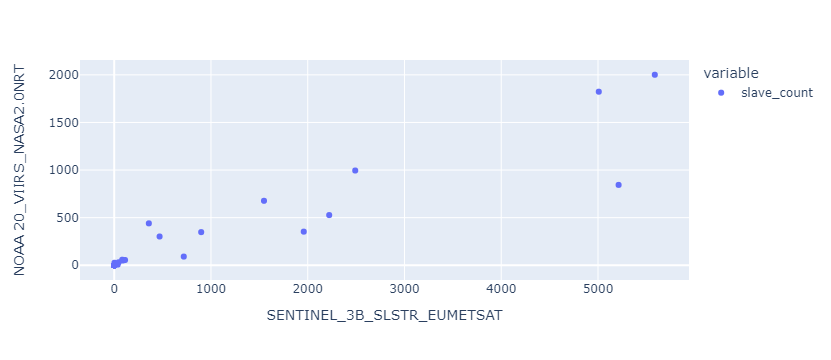

In [360]:
ax = candidate_pair.plot.scatter(x=candidate_pair['master_count'], y=['slave_count'])
ax.layout.xaxis = {    'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'SENTINEL_3B_SLSTR_EUMETSAT'}}
ax.layout.yaxis = {    'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'NOAA 20_VIIRS_NASA2.0NRT'}}
ax

# Candidate dates should be excluded from the pairwise comparison results if they fail two tests:
### 1. the ratio of counts for the pair exceeds a threshold of 3 standard deviations from the mean ratio (assumes that the ratio of hotspots will be reasonably stable)
### 2. the threshold of 3 standard deviations from the mean ratio is also exceeded in at least 4 other pairwise comparisons where the master / target satellite_sensor_product 

### Use the results to drop candidates matching the time and satellite_sensor_product (Master) from the nearest match results - chances are they get excluded from the <5000m results anyway

In [291]:
for date in filter_candidates_pd['gt3std'].unique():
    for i in filter_candidates_pd['satellite_sensor_product'].unique():
        candidate_product_count = filter_candidates_pd[(filter_candidates_pd['gt3std'] == date) & (filter_candidates_pd['satellite_sensor_product'] == i)].count()
        if candidate_product_count[0] >= 3:
            print(i, date, candidate_product_count[0])   

SENTINEL_3B_SLSTR_ESA 2019-12-24T00:00:00.000000000 5
SENTINEL_3B_SLSTR_EUMETSAT 2019-12-24T00:00:00.000000000 4
NOAA 20_VIIRS_NASA2.0NRT 2019-12-24T00:00:00.000000000 3
SENTINEL_3B_SLSTR_ESA 2020-01-08T00:00:00.000000000 3
TERRA_MODIS_LANDGATE 2020-01-08T00:00:00.000000000 3
SENTINEL_3B_SLSTR_EUMETSAT 2020-01-08T00:00:00.000000000 4
TERRA_MODIS_NASA6.03 2020-01-01T00:00:00.000000000 3
AQUA_MODIS_NASA6.03 2020-01-02T00:00:00.000000000 3
AQUA_MODIS_LANDGATE 2019-11-01T00:00:00.000000000 3
SENTINEL_3A_SLSTR_ESA 2020-01-10T00:00:00.000000000 4
SENTINEL_3A_SLSTR_EUMETSAT 2020-01-10T00:00:00.000000000 5
SENTINEL_3A_SLSTR_ESA 2019-12-22T00:00:00.000000000 3
SENTINEL_3A_SLSTR_EUMETSAT 2019-12-22T00:00:00.000000000 3
AQUA_MODIS_LANDGATE 2019-11-17T00:00:00.000000000 3
AQUA_MODIS_LANDGATE 2019-12-26T00:00:00.000000000 3
SENTINEL_3A_SLSTR_EUMETSAT 2019-12-26T00:00:00.000000000 3
TERRA_MODIS_LANDGATE 2019-12-27T00:00:00.000000000 3
AQUA_MODIS_LANDGATE 2019-12-27T00:00:00.000000000 3
TERRA_MODIS_N

In [24]:
filter_candidates_pd

,pair,satellite_sensor_product,2_satellite_sensor_product,gt3std
0,SENTINEL_3B_SLSTR_ESA|TERRA_MODIS_NASA6.03,SENTINEL_3B_SLSTR_ESA,TERRA_MODIS_NASA6.03,2019-12-24
0,SENTINEL_3B_SLSTR_ESA|TERRA_MODIS_LANDGATE,SENTINEL_3B_SLSTR_ESA,TERRA_MODIS_LANDGATE,2019-12-24
0,SENTINEL_3B_SLSTR_ESA|AQUA_MODIS_LANDGATE,SENTINEL_3B_SLSTR_ESA,AQUA_MODIS_LANDGATE,2019-12-24
0,SENTINEL_3B_SLSTR_ESA|AQUA_MODIS_NASA6.03,SENTINEL_3B_SLSTR_ESA,AQUA_MODIS_NASA6.03,2019-11-04
0,SENTINEL_3B_SLSTR_ESA|SUOMI NPP_VIIRS_LANDGATE,SENTINEL_3B_SLSTR_ESA,SUOMI NPP_VIIRS_LANDGATE,2020-01-08
...,...,...,...,...
0,NOAA 20_VIIRS_NASA2.0NRT|SUOMI NPP_VIIRS_NASA1,NOAA 20_VIIRS_NASA2.0NRT,SUOMI NPP_VIIRS_NASA1,2020-03-02
0,NOAA 20_VIIRS_NASA2.0NRT|NOAA 20_VIIRS_LANDGATE,NOAA 20_VIIRS_NASA2.0NRT,NOAA 20_VIIRS_LANDGATE,2020-01-04
0,NOAA 20_VIIRS_NASA2.0NRT|SENTINEL_3B_SLSTR_EUM...,NOAA 20_VIIRS_NASA2.0NRT,SENTINEL_3B_SLSTR_EUMETSAT,2019-12-10
1,NOAA 20_VIIRS_NASA2.0NRT|SENTINEL_3B_SLSTR_EUM...,NOAA 20_VIIRS_NASA2.0NRT,SENTINEL_3B_SLSTR_EUMETSAT,2020-01-02


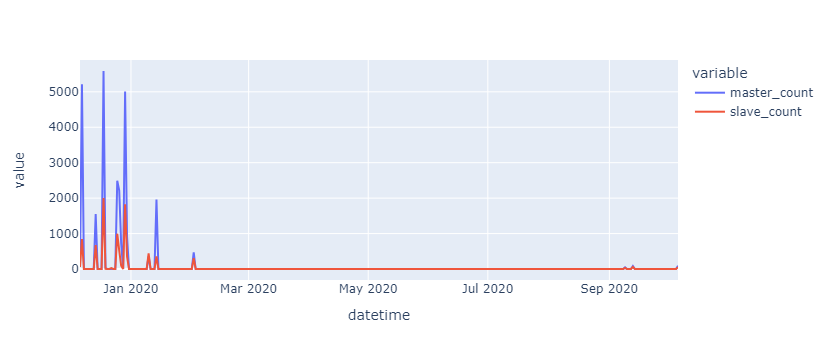

In [290]:
#sample = satellite_sensor_product_daily_pd[satellite_sensor_product_daily_pd['pair'] == 'SUOMI NPP_VIIRS_LANDGATE|SENTINEL_3B_SLSTR_EUMETSAT']
candidate_pair[['master_count', 'slave_count']].plot()

In [26]:
pd.options.plotting.backend = "plotly"
candidate_pair.plot(x=candidate_pair.index, y=['master_count', 'slave_count', 'ratio', 'zscore'])

In [27]:
import plotly.express as px
sample = satellite_sensor_product_daily_pd[satellite_sensor_product_daily_pd['pair'] == 'SENTINEL_3B_SLSTR_ESA|SENTINEL_3B_SLSTR_EUMETSAT']
#df = px.data.gapminder().query("continent=='Oceania'")
fig = px.line(sample, x=sample.index, y=sample['ratio'], color=sample['pair'])
fig.show()

In [28]:
satellite_sensor_product_daily_list[5]

,master_count,slave_count,ratio,zscore,satellite_sensor_product,2_satellite_sensor_product,pair
datetime,,,,,,,
2019-11-01,68,162,0.419753,0.134020,SENTINEL_3B_SLSTR_ESA,SUOMI NPP_VIIRS_LANDGATE,SENTINEL_3B_SLSTR_ESA|SUOMI NPP_VIIRS_LANDGATE
2019-11-02,0,0,NaN,NaN,SENTINEL_3B_SLSTR_ESA,SUOMI NPP_VIIRS_LANDGATE,SENTINEL_3B_SLSTR_ESA|SUOMI NPP_VIIRS_LANDGATE
2019-11-03,0,0,NaN,NaN,SENTINEL_3B_SLSTR_ESA,SUOMI NPP_VIIRS_LANDGATE,SENTINEL_3B_SLSTR_ESA|SUOMI NPP_VIIRS_LANDGATE
2019-11-04,312,89,3.505618,3.219885,SENTINEL_3B_SLSTR_ESA,SUOMI NPP_VIIRS_LANDGATE,SENTINEL_3B_SLSTR_ESA|SUOMI NPP_VIIRS_LANDGATE
2019-11-05,0,0,NaN,NaN,SENTINEL_3B_SLSTR_ESA,SUOMI NPP_VIIRS_LANDGATE,SENTINEL_3B_SLSTR_ESA|SUOMI NPP_VIIRS_LANDGATE
...,...,...,...,...,...,...,...
2020-01-09,13,124,0.104839,-0.180894,SENTINEL_3B_SLSTR_ESA,SUOMI NPP_VIIRS_LANDGATE,SENTINEL_3B_SLSTR_ESA|SUOMI NPP_VIIRS_LANDGATE
2020-01-10,0,0,NaN,NaN,SENTINEL_3B_SLSTR_ESA,SUOMI NPP_VIIRS_LANDGATE,SENTINEL_3B_SLSTR_ESA|SUOMI NPP_VIIRS_LANDGATE
2020-01-11,0,0,NaN,NaN,SENTINEL_3B_SLSTR_ESA,SUOMI NPP_VIIRS_LANDGATE,SENTINEL_3B_SLSTR_ESA|SUOMI NPP_VIIRS_LANDGATE


In [298]:
subset = nearest_points_ddf[(pd.to_datetime(nearest_points_ddf['datetime']).dt.date == np.datetime64('2019-12-24')) & (nearest_points_ddf['satellite_sensor_product'] == 'TERRA_MODIS_NASA6.03') & (nearest_points_ddf['2_satellite_sensor_product'] == 'SENTINEL_3B_SLSTR_ESA')]
#hotspots_gdf.plot(column='satellite_sensor_product', legend=True, legend_kwds={'loc': 'upper right'}, figsize=(20, 20))

In [299]:
subset

,Unnamed: 0,latitude,longitude,satellite,sensor,confidence,power,datetime,solar_day,satellite_sensor_product,...,2_power,2_datetime,2_solar_day,2_satellite_sensor_product,2_geometry,2_solar_night,dist,dist_m,timedelta,count
solar_night,,,,,,,,,,,,,,,,,,,,,
2019-12-24 10:09:46,107076,-32.9687,149.9421,TERRA,MODIS,-1.0,62.3,2019-12-24 12:10:00,2019-12-24 22:09:46,TERRA_MODIS_NASA6.03,...,1.00,2019-12-24 12:14:10,2019-12-24 22:13:55,SENTINEL_3B_SLSTR_ESA,POINT (149.9379056214432 -32.97200391675369),2019-12-24 10:13:55,0.005339,536.666847,0 days 00:04:10,1
2019-12-24 10:09:48,107077,-33.0626,149.9516,TERRA,MODIS,-1.0,35.4,2019-12-24 12:10:00,2019-12-24 22:09:48,TERRA_MODIS_NASA6.03,...,0.64,2019-12-24 12:14:08,2019-12-24 22:13:56,SENTINEL_3B_SLSTR_ESA,POINT (149.9506026214111 -33.06411091652114),2019-12-24 10:13:56,0.001810,191.715277,0 days 00:04:08,1
2019-12-24 10:09:49,107078,-33.0571,149.9556,TERRA,MODIS,-1.0,53.0,2019-12-24 12:10:00,2019-12-24 22:09:49,TERRA_MODIS_NASA6.03,...,0.86,2019-12-24 12:14:08,2019-12-24 22:13:58,SENTINEL_3B_SLSTR_ESA,POINT (149.9610296213848 -33.05995991653162),2019-12-24 10:13:58,0.006137,598.108568,0 days 00:04:08,1
2019-12-24 10:09:56,107079,-33.0447,149.9850,TERRA,MODIS,-1.0,30.9,2019-12-24 12:10:00,2019-12-24 22:09:56,TERRA_MODIS_NASA6.03,...,1.35,2019-12-24 12:14:08,2019-12-24 22:14:03,SENTINEL_3B_SLSTR_ESA,POINT (149.9803816213359 -33.04236691657604),2019-12-24 10:14:03,0.005174,503.040466,0 days 00:04:08,1


In [295]:
import folium
mapa = folium.Map([-26, 132],
                  zoom_start=4,
                  tiles='Stamen Terrain')

#points = folium.features.GeoJson(isochrons)
#mapa.add_child(points)
points = folium.features.GeoJson(gpd.GeoSeries.from_wkt(subset.geometry).to_json())
mapa.add_child(points)
mapa

In [31]:
satellite_sensor_product_daily.keys()

Index(['master_count', 'slave_count', 'ratio', 'zscore',
       'satellite_sensor_product', '2_satellite_sensor_product', 'pair'],
      dtype='object')

# Results
## Co-occurrence metrics

In [32]:
region_alias = "nsw"
output_directory = processing_parameters["outdir"]
comparison_prefix = (
    f"{processing_parameters['start_date'].replace('-', '')}"
    f"_{processing_parameters['end_date'].replace('-', '')}"
    f"_{processing_parameters['start_time'].replace(':','')}"
    f"_{processing_parameters['end_time'].replace(':','')}"
    f"_{region_alias}"
)

In [33]:
# set the nearest distance threshold between two hotspots to confine the analysis within the distance threshold.  
dist_threshold = 5000  # units in meters

In [34]:
nearest_ddf_dist_subset = nearest_points_ddf[nearest_points_ddf["dist_m"] < dist_threshold]

In [35]:
nearest_ddf_dist_subset

,Unnamed: 0,latitude,longitude,satellite,sensor,confidence,power,datetime,solar_day,satellite_sensor_product,...,2_power,2_datetime,2_solar_day,2_satellite_sensor_product,2_geometry,2_solar_night,dist,dist_m,timedelta,count
solar_night,,,,,,,,,,,,,,,,,,,,,
2019-11-01 10:01:39,219938,-29.873943,153.123579,SENTINEL_3B,SLSTR,-1.0,0.55,2019-11-01 11:49:10,2019-11-01 22:01:39,SENTINEL_3B_SLSTR_ESA,...,-1.0,2019-11-01 15:02:00,2019-11-02 01:14:34,AQUA_MODIS_LANDGATE,POINT (153.145 -29.865),2019-11-01 13:14:34,0.023213,2294.742586,0 days 03:12:50,1
2019-11-01 10:01:39,96675,-29.863303,153.123948,SENTINEL_3B,SLSTR,-1.0,0.46,2019-11-01 11:49:10,2019-11-01 22:01:39,SENTINEL_3B_SLSTR_ESA,...,0.7,2019-11-01 12:28:16,2019-11-01 22:40:49,SENTINEL_3A_SLSTR_ESA,POINT (153.1385216133624 -29.86785492459092),2019-11-01 10:40:49,0.015268,1495.762967,0 days 00:39:06,1
2019-11-01 10:01:39,96674,-29.873943,153.123579,SENTINEL_3B,SLSTR,-1.0,0.55,2019-11-01 11:49:10,2019-11-01 22:01:39,SENTINEL_3B_SLSTR_ESA,...,0.7,2019-11-01 12:28:16,2019-11-01 22:40:49,SENTINEL_3A_SLSTR_ESA,POINT (153.1385216133624 -29.86785492459092),2019-11-01 10:40:49,0.016136,1593.604978,0 days 00:39:06,1
2019-11-01 10:01:39,96673,-29.845804,153.119394,SENTINEL_3B,SLSTR,-1.0,0.32,2019-11-01 11:49:11,2019-11-01 22:01:39,SENTINEL_3B_SLSTR_ESA,...,0.7,2019-11-01 12:28:16,2019-11-01 22:40:49,SENTINEL_3A_SLSTR_ESA,POINT (153.1385216133624 -29.86785492459092),2019-11-01 10:40:49,0.029191,3064.446443,0 days 00:39:05,1
2019-11-01 10:01:39,96672,-29.863303,153.123948,SENTINEL_3B,SLSTR,-1.0,0.46,2019-11-01 11:49:10,2019-11-01 22:01:39,SENTINEL_3B_SLSTR_ESA,...,0.7,2019-11-01 12:28:16,2019-11-01 22:40:49,SENTINEL_3A_SLSTR_ESA,POINT (153.1385216133624 -29.86785492459092),2019-11-01 10:40:49,0.015268,1495.762967,0 days 00:39:06,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-07 12:38:27,248422,-32.316890,152.114790,NOAA 20,VIIRS,50.0,1.30,2020-10-07 14:30:00,2020-10-08 00:38:27,NOAA 20_VIIRS_NASA2.0NRT,...,1.3,2020-10-07 14:30:00,2020-10-08 00:38:27,NOAA 20_VIIRS_NASA2.0NRT,POINT (152.11479 -32.31689),2020-10-07 12:38:27,0.000000,0.000000,0 days 00:00:00,1
2020-10-07 12:39:45,248424,-28.848160,152.439010,NOAA 20,VIIRS,50.0,1.00,2020-10-07 14:30:00,2020-10-08 00:39:45,NOAA 20_VIIRS_NASA2.0NRT,...,1.0,2020-10-07 14:30:00,2020-10-08 00:39:45,NOAA 20_VIIRS_NASA2.0NRT,POINT (152.43901 -28.84816),2020-10-07 12:39:45,0.000000,0.000000,0 days 00:00:00,1
2020-10-07 12:39:46,248425,-28.849200,152.444310,NOAA 20,VIIRS,50.0,1.40,2020-10-07 14:30:00,2020-10-08 00:39:46,NOAA 20_VIIRS_NASA2.0NRT,...,1.4,2020-10-07 14:30:00,2020-10-08 00:39:46,NOAA 20_VIIRS_NASA2.0NRT,POINT (152.44431 -28.8492),2020-10-07 12:39:46,0.000000,0.000000,0 days 00:00:00,1


In [36]:
numerator = util.pandas_pivot_table(
    nearest_ddf_dist_subset,
    index=["satellite_sensor_product"],
    columns=["2_satellite_sensor_product"],
    values=["count"],
    aggfunc={"count": np.sum}
    
)

In [37]:
numerator.to_csv(output_directory.joinpath(f"{comparison_prefix}_matches_{dist_threshold}.csv"))
numerator

count                      \
2_satellite_sensor_product AQUA_MODIS_LANDGATE AQUA_MODIS_NASA6.03   
satellite_sensor_product                                             
AQUA_MODIS_LANDGATE                   104576.0             94563.0   
AQUA_MODIS_NASA6.03                    18483.0             21512.0   
NOAA 20_VIIRS_LANDGATE                300398.0            276722.0   
NOAA 20_VIIRS_NASA2.0NRT              165927.0            163821.0   
SENTINEL_3A_SLSTR_ESA                  11333.0              9507.0   
SENTINEL_3A_SLSTR_EUMETSAT              5032.0              4592.0   
SENTINEL_3B_SLSTR_ESA                  14561.0             16081.0   
SENTINEL_3B_SLSTR_EUMETSAT              5235.0              7600.0   
SUOMI NPP_VIIRS_LANDGATE              356982.0            343408.0   
SUOMI NPP_VIIRS_NASA1                 250393.0            238800.0   
TERRA_MODIS_LANDGATE                   66963.0             58536.0   
TERRA_MODIS_NASA6.03                   18265.0             16342.0   

                                                                            \
2_satellite_sensor_product NOAA 20_VIIRS_LANDGATE NOAA 20_VIIRS_NASA2.0NRT   
satellite_sensor_product                                                     
AQUA_MODIS_LANDGATE                       80809.0                  70349.0   
AQUA_MODIS_NASA6.03                       14468.0                  14879.0   
NOAA 20_VIIRS_LANDGATE                   416082.0                 310605.0   
NOAA 20_VIIRS_NASA2.0NRT                 199234.0                 248428.0   
SENTINEL_3A_SLSTR_ESA                     14530.0                   8136.0   
SENTINEL_3A_SLSTR_EUMETSAT                 7035.0                   8231.0   
SENTINEL_3B_SLSTR_ESA                     20948.0                  13489.0   
SENTINEL_3B_SLSTR_EUMETSAT                10497.0                  13758.0   
SUOMI NPP_VIIRS_LANDGATE                 353341.0                 331389.0   
SUOMI NPP_VIIRS_NASA1                    271257.0                 233410.0   
TERRA_MODIS_LANDGATE                      81333.0                  71929.0   
TERRA_MODIS_NASA6.03                      22077.0                  19416.0   

                                                                             \
2_satellite_sensor_product SENTINEL_3A_SLSTR_ESA SENTINEL_3A_SLSTR_EUMETSAT   
satellite_sensor_product                                                      
AQUA_MODIS_LANDGATE                      14320.0                     6733.0   
AQUA_MODIS_NASA6.03                       2430.0                     1250.0   
NOAA 20_VIIRS_LANDGATE                   58000.0                    26352.0   
NOAA 20_VIIRS_NASA2.0NRT                 23453.0                    23610.0   
SENTINEL_3A_SLSTR_ESA                    19121.0                     9287.0   
SENTINEL_3A_SLSTR_EUMETSAT                9267.0                     9406.0   
SENTINEL_3B_SLSTR_ESA                       66.0                        NaN   
SENTINEL_3B_SLSTR_EUMETSAT                   NaN                        NaN   
SUOMI NPP_VIIRS_LANDGATE                 50880.0                    34523.0   
SUOMI NPP_VIIRS_NASA1                    49846.0                    25463.0   
TERRA_MODIS_LANDGATE                     17185.0                     9347.0   
TERRA_MODIS_NASA6.03                      4313.0                     2408.0   

                                                                             \
2_satellite_sensor_product SENTINEL_3B_SLSTR_ESA SENTINEL_3B_SLSTR_EUMETSAT   
satellite_sensor_product                                                      
AQUA_MODIS_LANDGATE                      16398.0                     3087.0   
AQUA_MODIS_NASA6.03                       4721.0                     1781.0   
NOAA 20_VIIRS_LANDGATE                   69551.0                    35207.0   
NOAA 20_VIIRS_NASA2.0NRT                 30998.0                    31364.0   
SENTINEL_3A_SLSTR_ESA                       34.0                        NaN   
S

In [38]:
denominator = util.pandas_pivot_table(
    nearest_points_ddf,
    index=["satellite_sensor_product"],
    columns=["2_satellite_sensor_product"],
    values=["count"],
    aggfunc={"count": np.sum}
    
)

In [39]:
denominator.to_csv(output_directory.joinpath(f"{comparison_prefix}_matches_count.csv"))
denominator

count                      \
2_satellite_sensor_product AQUA_MODIS_LANDGATE AQUA_MODIS_NASA6.03   
satellite_sensor_product                                             
AQUA_MODIS_LANDGATE                   104576.0            103922.0   
AQUA_MODIS_NASA6.03                    19932.0             21512.0   
NOAA 20_VIIRS_LANDGATE                374549.0            365744.0   
NOAA 20_VIIRS_NASA2.0NRT              223206.0            226415.0   
SENTINEL_3A_SLSTR_ESA                  15697.0             16323.0   
SENTINEL_3A_SLSTR_EUMETSAT              7264.0              8016.0   
SENTINEL_3B_SLSTR_ESA                  23301.0             26502.0   
SENTINEL_3B_SLSTR_EUMETSAT             12413.0             15324.0   
SUOMI NPP_VIIRS_LANDGATE              425530.0            427020.0   
SUOMI NPP_VIIRS_NASA1                 315970.0            327532.0   
TERRA_MODIS_LANDGATE                   88004.0             89697.0   
TERRA_MODIS_NASA6.03                   23804.0             24311.0   

                                                                            \
2_satellite_sensor_product NOAA 20_VIIRS_LANDGATE NOAA 20_VIIRS_NASA2.0NRT   
satellite_sensor_product                                                     
AQUA_MODIS_LANDGATE                      104100.0                  70815.0   
AQUA_MODIS_NASA6.03                       20617.0                  14956.0   
NOAA 20_VIIRS_LANDGATE                   416082.0                 311977.0   
NOAA 20_VIIRS_NASA2.0NRT                 238970.0                 248428.0   
SENTINEL_3A_SLSTR_ESA                     17744.0                   8531.0   
SENTINEL_3A_SLSTR_EUMETSAT                 8591.0                   8641.0   
SENTINEL_3B_SLSTR_ESA                     24165.0                  14557.0   
SENTINEL_3B_SLSTR_EUMETSAT                12402.0                  14909.0   
SUOMI NPP_VIIRS_LANDGATE                 454945.0                 340453.0   
SUOMI NPP_VIIRS_NASA1                    341159.0                 240569.0   
TERRA_MODIS_LANDGATE                      99240.0                  73997.0   
TERRA_MODIS_NASA6.03                      26815.0                  20032.0   

                                                                             \
2_satellite_sensor_product SENTINEL_3A_SLSTR_ESA SENTINEL_3A_SLSTR_EUMETSAT   
satellite_sensor_product                                                      
AQUA_MODIS_LANDGATE                      16034.0                     7910.0   
AQUA_MODIS_NASA6.03                       2786.0                     1506.0   
NOAA 20_VIIRS_LANDGATE                   62654.0                    29562.0   
NOAA 20_VIIRS_NASA2.0NRT                 26635.0                    26853.0   
SENTINEL_3A_SLSTR_ESA                    19121.0                     9297.0   
SENTINEL_3A_SLSTR_EUMETSAT                9267.0                     9406.0   
SENTINEL_3B_SLSTR_ESA                       68.0                        NaN   
SENTINEL_3B_SLSTR_EUMETSAT                   NaN                        NaN   
SUOMI NPP_VIIRS_LANDGATE                 58290.0                    39981.0   
SUOMI NPP_VIIRS_NASA1                    55922.0                    28938.0   
TERRA_MODIS_LANDGATE                     18074.0                     9782.0   
TERRA_MODIS_NASA6.03                      4517.0                     2512.0   

                                                                             \
2_satellite_sensor_product SENTINEL_3B_SLSTR_ESA SENTINEL_3B_SLSTR_EUMETSAT   
satellite_sensor_product                                                      
AQUA_MODIS_LANDGATE                      17430.0                     3873.0   
AQUA_MODIS_NASA6.03                       5155.0                     2170.0   
NOAA 20_VIIRS_LANDGATE                   78336.0                    43669.0   
NOAA 20_VIIRS_NASA2.0NRT                 37880.0                    38392.0   
SENTINEL_3A_SLSTR_ESA                       88.0                        NaN   
S

In [40]:
# Difference of matched points closer than 5000m
difference = denominator - numerator

In [41]:
difference.to_csv(output_directory.joinpath(f"{comparison_prefix}_count_difference.csv"))
difference

count                      \
2_satellite_sensor_product AQUA_MODIS_LANDGATE AQUA_MODIS_NASA6.03   
satellite_sensor_product                                             
AQUA_MODIS_LANDGATE                        0.0              9359.0   
AQUA_MODIS_NASA6.03                     1449.0                 0.0   
NOAA 20_VIIRS_LANDGATE                 74151.0             89022.0   
NOAA 20_VIIRS_NASA2.0NRT               57279.0             62594.0   
SENTINEL_3A_SLSTR_ESA                   4364.0              6816.0   
SENTINEL_3A_SLSTR_EUMETSAT              2232.0              3424.0   
SENTINEL_3B_SLSTR_ESA                   8740.0             10421.0   
SENTINEL_3B_SLSTR_EUMETSAT              7178.0              7724.0   
SUOMI NPP_VIIRS_LANDGATE               68548.0             83612.0   
SUOMI NPP_VIIRS_NASA1                  65577.0             88732.0   
TERRA_MODIS_LANDGATE                   21041.0             31161.0   
TERRA_MODIS_NASA6.03                    5539.0              7969.0   

                                                                            \
2_satellite_sensor_product NOAA 20_VIIRS_LANDGATE NOAA 20_VIIRS_NASA2.0NRT   
satellite_sensor_product                                                     
AQUA_MODIS_LANDGATE                       23291.0                    466.0   
AQUA_MODIS_NASA6.03                        6149.0                     77.0   
NOAA 20_VIIRS_LANDGATE                        0.0                   1372.0   
NOAA 20_VIIRS_NASA2.0NRT                  39736.0                      0.0   
SENTINEL_3A_SLSTR_ESA                      3214.0                    395.0   
SENTINEL_3A_SLSTR_EUMETSAT                 1556.0                    410.0   
SENTINEL_3B_SLSTR_ESA                      3217.0                   1068.0   
SENTINEL_3B_SLSTR_EUMETSAT                 1905.0                   1151.0   
SUOMI NPP_VIIRS_LANDGATE                 101604.0                   9064.0   
SUOMI NPP_VIIRS_NASA1                     69902.0                   7159.0   
TERRA_MODIS_LANDGATE                      17907.0                   2068.0   
TERRA_MODIS_NASA6.03                       4738.0                    616.0   

                                                                             \
2_satellite_sensor_product SENTINEL_3A_SLSTR_ESA SENTINEL_3A_SLSTR_EUMETSAT   
satellite_sensor_product                                                      
AQUA_MODIS_LANDGATE                       1714.0                     1177.0   
AQUA_MODIS_NASA6.03                        356.0                      256.0   
NOAA 20_VIIRS_LANDGATE                    4654.0                     3210.0   
NOAA 20_VIIRS_NASA2.0NRT                  3182.0                     3243.0   
SENTINEL_3A_SLSTR_ESA                        0.0                       10.0   
SENTINEL_3A_SLSTR_EUMETSAT                   0.0                        0.0   
SENTINEL_3B_SLSTR_ESA                        2.0                        NaN   
SENTINEL_3B_SLSTR_EUMETSAT                   NaN                        NaN   
SUOMI NPP_VIIRS_LANDGATE                  7410.0                     5458.0   
SUOMI NPP_VIIRS_NASA1                     6076.0                     3475.0   
TERRA_MODIS_LANDGATE                       889.0                      435.0   
TERRA_MODIS_NASA6.03                       204.0                      104.0   

                                                                             \
2_satellite_sensor_product SENTINEL_3B_SLSTR_ESA SENTINEL_3B_SLSTR_EUMETSAT   
satellite_sensor_product                                                      
AQUA_MODIS_LANDGATE                       1032.0                      786.0   
AQUA_MODIS_NASA6.03                        434.0                      389.0   
NOAA 20_VIIRS_LANDGATE                    8785.0                     8462.0   
NOAA 20_VIIRS_NASA2.0NRT                  6882.0                     7028.0   
SENTINEL_3A_SLSTR_ESA                       54.0                        NaN   
S

In [42]:
# Percentage of matched points closer than dist_threshold
percentage = (numerator / denominator) * 100
percentage = np.round(percentage, 2)

In [43]:
# Add a colum which provides the average percentage

In [44]:
percentage.to_csv(output_directory.joinpath(f"{comparison_prefix}_percentage.csv"))
percentage

count                      \
2_satellite_sensor_product AQUA_MODIS_LANDGATE AQUA_MODIS_NASA6.03   
satellite_sensor_product                                             
AQUA_MODIS_LANDGATE                     100.00               90.99   
AQUA_MODIS_NASA6.03                      92.73              100.00   
NOAA 20_VIIRS_LANDGATE                   80.20               75.66   
NOAA 20_VIIRS_NASA2.0NRT                 74.34               72.35   
SENTINEL_3A_SLSTR_ESA                    72.20               58.24   
SENTINEL_3A_SLSTR_EUMETSAT               69.27               57.29   
SENTINEL_3B_SLSTR_ESA                    62.49               60.68   
SENTINEL_3B_SLSTR_EUMETSAT               42.17               49.60   
SUOMI NPP_VIIRS_LANDGATE                 83.89               80.42   
SUOMI NPP_VIIRS_NASA1                    79.25               72.91   
TERRA_MODIS_LANDGATE                     76.09               65.26   
TERRA_MODIS_NASA6.03                     76.73               67.22   

                                                                            \
2_satellite_sensor_product NOAA 20_VIIRS_LANDGATE NOAA 20_VIIRS_NASA2.0NRT   
satellite_sensor_product                                                     
AQUA_MODIS_LANDGATE                         77.63                    99.34   
AQUA_MODIS_NASA6.03                         70.18                    99.49   
NOAA 20_VIIRS_LANDGATE                     100.00                    99.56   
NOAA 20_VIIRS_NASA2.0NRT                    83.37                   100.00   
SENTINEL_3A_SLSTR_ESA                       81.89                    95.37   
SENTINEL_3A_SLSTR_EUMETSAT                  81.89                    95.26   
SENTINEL_3B_SLSTR_ESA                       86.69                    92.66   
SENTINEL_3B_SLSTR_EUMETSAT                  84.64                    92.28   
SUOMI NPP_VIIRS_LANDGATE                    77.67                    97.34   
SUOMI NPP_VIIRS_NASA1                       79.51                    97.02   
TERRA_MODIS_LANDGATE                        81.96                    97.21   
TERRA_MODIS_NASA6.03                        82.33                    96.92   

                                                                             \
2_satellite_sensor_product SENTINEL_3A_SLSTR_ESA SENTINEL_3A_SLSTR_EUMETSAT   
satellite_sensor_product                                                      
AQUA_MODIS_LANDGATE                        89.31                      85.12   
AQUA_MODIS_NASA6.03                        87.22                      83.00   
NOAA 20_VIIRS_LANDGATE                     92.57                      89.14   
NOAA 20_VIIRS_NASA2.0NRT                   88.05                      87.92   
SENTINEL_3A_SLSTR_ESA                     100.00                      99.89   
SENTINEL_3A_SLSTR_EUMETSAT                100.00                     100.00   
SENTINEL_3B_SLSTR_ESA                      97.06                        NaN   
SENTINEL_3B_SLSTR_EUMETSAT                   NaN                        NaN   
SUOMI NPP_VIIRS_LANDGATE                   87.29                      86.35   
SUOMI NPP_VIIRS_NASA1                      89.13                      87.99   
TERRA_MODIS_LANDGATE                       95.08                      95.55   
TERRA_MODIS_NASA6.03                       95.48                      95.86   

                                                                             \
2_satellite_sensor_product SENTINEL_3B_SLSTR_ESA SENTINEL_3B_SLSTR_EUMETSAT   
satellite_sensor_product                                                      
AQUA_MODIS_LANDGATE                        94.08                      79.71   
AQUA_MODIS_NASA6.03                        91.58                      82.07   
NOAA 20_VIIRS_LANDGATE                     88.79                      80.62   
NOAA 20_VIIRS_NASA2.0NRT                   81.83                      81.69   
SENTINEL_3A_SLSTR_ESA                      38.64                        NaN   
S

In [45]:
# Maximum time between match points < dist_threshold
timemax = util.pandas_pivot_table(
    nearest_ddf_dist_subset,
    index=["satellite_sensor_product"],
    columns=["2_satellite_sensor_product"],
    values=["timedelta"],
    aggfunc={"timedelta": np.max}
    
)

In [46]:
timemax.to_csv(output_directory.joinpath(f"{comparison_prefix}_max_time_matched_points.csv"))
timemax

timedelta                      \
2_satellite_sensor_product AQUA_MODIS_LANDGATE AQUA_MODIS_NASA6.03   
satellite_sensor_product                                             
AQUA_MODIS_LANDGATE            0 days 01:47:00     0 days 01:44:00   
AQUA_MODIS_NASA6.03            0 days 01:44:00     0 days 00:00:00   
NOAA 20_VIIRS_LANDGATE         0 days 01:30:00     0 days 01:28:00   
NOAA 20_VIIRS_NASA2.0NRT       0 days 01:55:00     0 days 01:51:00   
SENTINEL_3A_SLSTR_ESA          0 days 03:58:44     0 days 04:00:12   
SENTINEL_3A_SLSTR_EUMETSAT     0 days 03:58:44     0 days 03:53:42   
SENTINEL_3B_SLSTR_ESA          0 days 03:55:46     0 days 03:45:39   
SENTINEL_3B_SLSTR_EUMETSAT     0 days 03:51:40     0 days 03:45:39   
SUOMI NPP_VIIRS_LANDGATE       0 days 01:52:00     0 days 01:48:00   
SUOMI NPP_VIIRS_NASA1          0 days 02:09:00     0 days 02:04:00   
TERRA_MODIS_LANDGATE           0 days 03:28:00     0 days 03:24:00   
TERRA_MODIS_NASA6.03           0 days 03:22:00     0 days 03:17:00   

                                                                            \
2_satellite_sensor_product NOAA 20_VIIRS_LANDGATE NOAA 20_VIIRS_NASA2.0NRT   
satellite_sensor_product                                                     
AQUA_MODIS_LANDGATE               0 days 01:30:00          0 days 01:55:00   
AQUA_MODIS_NASA6.03               0 days 01:28:00          0 days 01:51:00   
NOAA 20_VIIRS_LANDGATE            0 days 01:44:00          0 days 01:45:00   
NOAA 20_VIIRS_NASA2.0NRT          0 days 01:45:00          0 days 00:00:00   
SENTINEL_3A_SLSTR_ESA             0 days 04:03:23          0 days 04:01:25   
SENTINEL_3A_SLSTR_EUMETSAT        0 days 04:03:23          0 days 04:01:25   
SENTINEL_3B_SLSTR_ESA             0 days 03:53:03          0 days 03:51:03   
SENTINEL_3B_SLSTR_EUMETSAT        0 days 03:58:08          0 days 03:57:44   
SUOMI NPP_VIIRS_LANDGATE          0 days 00:58:00          0 days 01:00:00   
SUOMI NPP_VIIRS_NASA1             0 days 01:00:00          0 days 00:56:00   
TERRA_MODIS_LANDGATE              0 days 04:06:00          0 days 03:55:00   
TERRA_MODIS_NASA6.03              0 days 04:02:00          0 days 03:38:00   

                                                                             \
2_satellite_sensor_product SENTINEL_3A_SLSTR_ESA SENTINEL_3A_SLSTR_EUMETSAT   
satellite_sensor_product                                                      
AQUA_MODIS_LANDGATE              0 days 03:58:43            0 days 03:58:43   
AQUA_MODIS_NASA6.03              0 days 04:00:12            0 days 03:53:42   
NOAA 20_VIIRS_LANDGATE           0 days 04:03:30            0 days 04:03:30   
NOAA 20_VIIRS_NASA2.0NRT         0 days 04:01:30            0 days 04:01:29   
SENTINEL_3A_SLSTR_ESA            0 days 00:00:01            0 days 00:00:01   
SENTINEL_3A_SLSTR_EUMETSAT       0 days 00:00:01            0 days 00:00:01   
SENTINEL_3B_SLSTR_ESA            0 days 00:39:07                        NaT   
SENTINEL_3B_SLSTR_EUMETSAT                   NaT                        NaT   
SUOMI NPP_VIIRS_LANDGATE         0 days 03:56:33            0 days 04:03:31   
SUOMI NPP_VIIRS_NASA1            0 days 04:04:17            0 days 03:50:42   
TERRA_MODIS_LANDGATE             0 days 01:44:42            0 days 01:44:42   
TERRA_MODIS_NASA6.03             0 days 01:34:39            0 days 01:34:39   

                                                                             \
2_satellite_sensor_product SENTINEL_3B_SLSTR_ESA SENTINEL_3B_SLSTR_EUMETSAT   
satellite_sensor_product                                                      
AQUA_MODIS_LANDGATE              0 days 03:55:46            0 days 03:51:39   
AQUA_MODIS_NASA6.03              0 days 03:45:39            0 days 03:45:39   
NOAA 20_VIIRS_LANDGATE           0 days 03:53:03            0 days 03:58:44   
NOAA 20_VIIRS_NASA2.0NRT         0 days 03:51:03            0 days 03:57:44   
SENTINEL_3A_SLSTR_ESA            0 days 00:39:07                        NaT 

In [47]:
# Minimum time between match points < dist_threshold
timemin = util.pandas_pivot_table(
    nearest_ddf_dist_subset,
    index=["satellite_sensor_product"],
    columns=["2_satellite_sensor_product"],
    values=["timedelta"],
    aggfunc={"timedelta": np.min}
)

In [48]:
timemin.to_csv(output_directory.joinpath(f"{comparison_prefix}_min_time_matched_points.csv"))
timemin

timedelta                      \
2_satellite_sensor_product AQUA_MODIS_LANDGATE AQUA_MODIS_NASA6.03   
satellite_sensor_product                                             
AQUA_MODIS_LANDGATE            0 days 00:00:00     0 days 00:00:00   
AQUA_MODIS_NASA6.03            0 days 00:00:00     0 days 00:00:00   
NOAA 20_VIIRS_LANDGATE         0 days 00:00:00     0 days 00:00:00   
NOAA 20_VIIRS_NASA2.0NRT       0 days 00:04:00     0 days 00:00:00   
SENTINEL_3A_SLSTR_ESA          0 days 01:37:24     0 days 01:56:32   
SENTINEL_3A_SLSTR_EUMETSAT     0 days 01:37:24     0 days 02:01:42   
SENTINEL_3B_SLSTR_ESA          0 days 01:54:38     0 days 01:57:38   
SENTINEL_3B_SLSTR_EUMETSAT     0 days 01:54:38     0 days 01:57:38   
SUOMI NPP_VIIRS_LANDGATE       0 days 00:00:00     0 days 00:02:00   
SUOMI NPP_VIIRS_NASA1          0 days 00:00:00     0 days 00:00:00   
TERRA_MODIS_LANDGATE           0 days 01:15:00     0 days 01:24:00   
TERRA_MODIS_NASA6.03           0 days 01:24:00     0 days 01:33:00   

                                                                            \
2_satellite_sensor_product NOAA 20_VIIRS_LANDGATE NOAA 20_VIIRS_NASA2.0NRT   
satellite_sensor_product                                                     
AQUA_MODIS_LANDGATE               0 days 00:00:00          0 days 00:04:00   
AQUA_MODIS_NASA6.03               0 days 00:00:00          0 days 00:00:00   
NOAA 20_VIIRS_LANDGATE            0 days 00:00:00          0 days 00:00:00   
NOAA 20_VIIRS_NASA2.0NRT          0 days 00:00:00          0 days 00:00:00   
SENTINEL_3A_SLSTR_ESA             0 days 01:08:08          0 days 01:43:59   
SENTINEL_3A_SLSTR_EUMETSAT        0 days 01:57:54          0 days 01:43:59   
SENTINEL_3B_SLSTR_ESA             0 days 01:39:25          0 days 01:31:41   
SENTINEL_3B_SLSTR_EUMETSAT        0 days 01:39:25          0 days 01:31:41   
SUOMI NPP_VIIRS_LANDGATE          0 days 00:44:00          0 days 00:40:00   
SUOMI NPP_VIIRS_NASA1             0 days 00:39:00          0 days 00:44:00   
TERRA_MODIS_LANDGATE              0 days 00:32:00          0 days 00:01:00   
TERRA_MODIS_NASA6.03              0 days 01:07:00          0 days 00:06:00   

                                                                             \
2_satellite_sensor_product SENTINEL_3A_SLSTR_ESA SENTINEL_3A_SLSTR_EUMETSAT   
satellite_sensor_product                                                      
AQUA_MODIS_LANDGATE              0 days 01:37:24            0 days 01:37:24   
AQUA_MODIS_NASA6.03              0 days 01:56:33            0 days 02:01:42   
NOAA 20_VIIRS_LANDGATE           0 days 01:08:08            0 days 01:57:54   
NOAA 20_VIIRS_NASA2.0NRT         0 days 01:43:59            0 days 01:43:59   
SENTINEL_3A_SLSTR_ESA            0 days 00:00:00            0 days 00:00:00   
SENTINEL_3A_SLSTR_EUMETSAT       0 days 00:00:00            0 days 00:00:00   
SENTINEL_3B_SLSTR_ESA            0 days 00:39:05                        NaT   
SENTINEL_3B_SLSTR_EUMETSAT                   NaT                        NaT   
SUOMI NPP_VIIRS_LANDGATE         0 days 01:56:08            0 days 01:52:11   
SUOMI NPP_VIIRS_NASA1            0 days 01:15:54            0 days 01:15:54   
TERRA_MODIS_LANDGATE             0 days 00:00:10            0 days 00:00:10   
TERRA_MODIS_NASA6.03             0 days 00:00:20            0 days 00:02:32   

                                                                             \
2_satellite_sensor_product SENTINEL_3B_SLSTR_ESA SENTINEL_3B_SLSTR_EUMETSAT   
satellite_sensor_product                                                      
AQUA_MODIS_LANDGATE              0 days 01:54:38            0 days 01:54:38   
AQUA_MODIS_NASA6.03              0 days 01:57:38            0 days 01:57:38   
NOAA 20_VIIRS_LANDGATE           0 days 01:39:25            0 days 01:39:25   
NOAA 20_VIIRS_NASA2.0NRT         0 days 01:31:41            0 days 01:31:41   
SENTINEL_3A_SLSTR_ESA            0 days 00:39:06                        NaT 

In [49]:
# Average distance (m) between matched points < dist_threshold
averagedist = util.pandas_pivot_table(
    nearest_ddf_dist_subset,
    index=["satellite_sensor_product"],
    columns=["2_satellite_sensor_product"],
    values=["dist_m"],
    aggfunc={"dist_m": np.mean}
)

In [50]:
averagedist = np.round(averagedist, 2)
averagedist.to_csv(output_directory.joinpath(f"{comparison_prefix}_average_distance_{dist_threshold}m.csv"))
averagedist

dist_m                      \
2_satellite_sensor_product AQUA_MODIS_LANDGATE AQUA_MODIS_NASA6.03   
satellite_sensor_product                                             
AQUA_MODIS_LANDGATE                       0.00              900.39   
AQUA_MODIS_NASA6.03                     118.97                0.00   
NOAA 20_VIIRS_LANDGATE                  843.19             1238.23   
NOAA 20_VIIRS_NASA2.0NRT                956.40             1293.85   
SENTINEL_3A_SLSTR_ESA                  1258.49             1682.53   
SENTINEL_3A_SLSTR_EUMETSAT             1308.89             1679.14   
SENTINEL_3B_SLSTR_ESA                  1419.63             1682.43   
SENTINEL_3B_SLSTR_EUMETSAT             1976.67             1885.11   
SUOMI NPP_VIIRS_LANDGATE                810.65             1177.67   
SUOMI NPP_VIIRS_NASA1                   925.11             1303.12   
TERRA_MODIS_LANDGATE                   1001.53             1484.71   
TERRA_MODIS_NASA6.03                    955.80             1299.64   

                                                                            \
2_satellite_sensor_product NOAA 20_VIIRS_LANDGATE NOAA 20_VIIRS_NASA2.0NRT   
satellite_sensor_product                                                     
AQUA_MODIS_LANDGATE                        658.43                   561.49   
AQUA_MODIS_NASA6.03                        435.48                   358.24   
NOAA 20_VIIRS_LANDGATE                       0.00                   216.03   
NOAA 20_VIIRS_NASA2.0NRT                   443.42                     0.00   
SENTINEL_3A_SLSTR_ESA                      743.90                   512.23   
SENTINEL_3A_SLSTR_EUMETSAT                 717.01                   513.76   
SENTINEL_3B_SLSTR_ESA                     1076.07                   830.25   
SENTINEL_3B_SLSTR_EUMETSAT                1143.51                   826.26   
SUOMI NPP_VIIRS_LANDGATE                   413.14                   342.28   
SUOMI NPP_VIIRS_NASA1                      545.03                   350.25   
TERRA_MODIS_LANDGATE                       599.29                   502.84   
TERRA_MODIS_NASA6.03                       477.04                   360.40   

                                                                             \
2_satellite_sensor_product SENTINEL_3A_SLSTR_ESA SENTINEL_3A_SLSTR_EUMETSAT   
satellite_sensor_product                                                      
AQUA_MODIS_LANDGATE                       797.42                     791.79   
AQUA_MODIS_NASA6.03                       627.02                     641.36   
NOAA 20_VIIRS_LANDGATE                    582.21                     633.88   
NOAA 20_VIIRS_NASA2.0NRT                  636.41                     636.35   
SENTINEL_3A_SLSTR_ESA                       0.00                       0.64   
SENTINEL_3A_SLSTR_EUMETSAT                  0.44                       0.00   
SENTINEL_3B_SLSTR_ESA                    1086.27                        NaN   
SENTINEL_3B_SLSTR_EUMETSAT                   NaN                        NaN   
SUOMI NPP_VIIRS_LANDGATE                  617.93                     629.50   
SUOMI NPP_VIIRS_NASA1                     600.95                     606.44   
TERRA_MODIS_LANDGATE                      596.35                     620.10   
TERRA_MODIS_NASA6.03                      508.89                     515.99   

                                                                             \
2_satellite_sensor_product SENTINEL_3B_SLSTR_ESA SENTINEL_3B_SLSTR_EUMETSAT   
satellite_sensor_product                                                      
AQUA_MODIS_LANDGATE                       742.71                     991.74   
AQUA_MODIS_NASA6.03                       607.58                     678.87   
NOAA 20_VIIRS_LANDGATE                    630.36                     674.20   
NOAA 20_VIIRS_NASA2.0NRT                  636.05                     634.22   
SENTINEL_3A_SLSTR_ESA                     659.64                        NaN   


In [51]:
#client.close() # close dask.distributed client